# Step 0: Exploratory Data Analysis

Explore the data and share your insights!

In [1]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import cv2

import os
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K

from sklearn.metrics import accuracy_score
import glob, random

import numpy as np
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
import keras.backend as K

from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau,CSVLogger,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,roc_auc_score
from sklearn.metrics import cohen_kappa_score,classification_report,auc,roc_curve
from keras.callbacks import Callback
from keras.layers import Dense

from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

### Define the paths for the dataset 

In [2]:
# Since the work for this take home challenge is dine Google Colab, mounting google drive here
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_path=pathlib.Path("/content/gdrive/My Drive/Colab Data/Data/")
# data_path = pathlib.Path("Data") 
image_path = data_path/  'fundus_images'
simple_model_subset_path = data_path/ 'simple_model_subset.csv'
cnn_subset_path = data_path/ 'cnn_subset.csv'


### Load the label files

In [4]:
simple_model_subset = pd.read_csv(simple_model_subset_path, index_col=0)

cnn_subset = pd.read_csv(cnn_subset_path, index_col=0)


In [ ]:
print(simple_model_subset)
print(cnn_subset)

### Define a function for loading images

In [6]:
# Loading a single image at a time, resizing it to a constant size in order to avoid discrepancies while plotting images or building models
def image_loader(image_path):
  image=cv2.imread(image_path)
  resized_image=cv2.resize(image, (768,768))
  return resized_image

### Define a function for plotting sample images with their labels 

In [7]:
def plot_image(image_path, label=-1, plt_axes=121):
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))                       # Using matplotlib for plotting images
  plt.subplot(plt_axes)

  image=image_loader(image_path)                                                # Calling image loader function to load images
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

  if label==-1:                                                                 # If the label does not exist, here the example images, we speciy that it is not given
    plt.title(image_path.split('/')[-1]+"  :  "+ "Self-explanatory Image Name")
  elif label==0:
    plt.title(image_path.split('/')[-1]+"  :  "+ "Good Quality Image")
  else:
    plt.title(image_path.split('/')[-1]+"  :  "+ "Bad Quality Image")
  plt.show()


In [ ]:
# Plot example images and see if the above functions work
example_images="/content/gdrive/My Drive/Colab Data/Data/examples/"
sample_images=glob.glob(example_images+'*')

for image in sample_images:
  plot_image(image)

### Plot and observe the differences between the bad and good images on a data subset 

In [ ]:
#Plot some good quality images randomly

good_quality_images=simple_model_subset.loc[simple_model_subset['quality']==0]

for idx, row in good_quality_images.sample(25).iterrows():
  plot_image(str(image_path)+'/'+row['image'], label=row['quality'], plt_axes=121)

In [ ]:
# Plot some bad quality images randomly

bad_quality_images=simple_model_subset.loc[simple_model_subset['quality']==1]

for idx, row in bad_quality_images.sample(25).iterrows():
  plot_image(str(image_path)+'/'+row['image'], label=row['quality'], plt_axes=121)

### Explore the Data 

In [40]:
# Check the prevalence of  bad quality images in both the sets

percentage_of_bad_quality_images=(sum(simple_model_subset['quality'])*100/len(simple_model_subset))
print ("Prevalence of Bad quality Images: "+ str(percentage_of_bad_quality_images ))

percentage_of_bad_quality_images=(sum(cnn_subset['quality'])*100/len(cnn_subset))
print ("Prevalence of Bad quality Images: "+ str(percentage_of_bad_quality_images ))

# Now that we know that the classes are balanced, we will use the default loss functions and not penalize one above the other.

Prevalence of Bad quality Images: 50.0
Prevalence of Bad quality Images: 50.0


In [ ]:
# Now let's check the pixel values in the images

images=np.zeros((len(simple_model_subset),768,768,3))

for idx, row in simple_model_subset.iterrows():
  image=image_loader(str(image_path)+'/'+row['image'])
  images[idx]=image
  print ("Processing: "+ str(idx)+ "th image")

In [49]:
print (np.min(images), np.max(images))

# The images look normalized in a particular range, so we won't probably have to work on fixing the ranges by the looks of it

0.0 255.0


# Step 1: Simple Model 

Now that we gained insights about the dataset, we can start building models for predicting image quality. In this section, build a model for classifying the images into good and bad classes only using the small data subset. This subset has 300 images from good (label 0) and bad (label 1) classes. Given the size of the dataset, we do not expect you to train a neural network in this section. Feel free to use any other model you like. 

In [ ]:
# Preparing Data 

In [36]:
# Split the data keeping in mind the prevalence(Stratifed split)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(list(simple_model_subset['image']),list(simple_model_subset['quality']),test_size=0.20,random_state=42,stratify=list(simple_model_subset['quality']))

In [ ]:
images=np.zeros((len(X_train),64*64*3))
labels=[0]*len(X_train)

for idx, row in enumerate(X_train):
  image=image_loader(str(image_path)+'/'+row)
  image=cv2.resize(image, (64, 64))
  images[idx]=image.flatten()
  labels[idx]=Y_train[idx]
  print ("Processing: "+ str(idx)+ "th image")

labels=np.array(labels)

x_train /= 255.


In [ ]:
images=np.zeros((len(X_test),64*64*3))
labels=[0]*len(X_test)

for idx, row in enumerate(X_test):
  image=image_loader(str(image_path)+'/'+row)
  image=cv2.resize(image, (64, 64))
  images[idx]=image.flatten()
  labels[idx]=Y_test[idx]
  print ("Processing: "+ str(idx)+ "th image")

labels=np.array(labels)

x_test /= 255.

### Q: Define a model for training 

Tell us why you picked this model. What are the advantages/disadvantages?

### Your Answer:

In [ ]:
# XGboost is a ensemble-tree based classifier. The boosting algorithms work on iterative classification minimizing error in subsequent trees. The final ensemble usually helps build the best one. 
# Since images have a ton of features, I think other algorithms are too like KNN are too simple and might underfit when trained on more amoount of data.
# Decision trees on the other hand are prone to overfitting and might not generalize well.

In [40]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics 

model = xgb.XGBClassifier()

### Q: Metrics

- Explain what metrics you will use for evaluating model performance. 
- If the task was multi level classification (good, accept, bad), what metrics would you be looking at?
- In the case where data is not evenly distributed accross classes, how would you modify the mentioned metrics or add other metrics to best present your model performance?

### Your Answer: 

In [ ]:
'''
1. Generally, I would prefer looking at the classification report and the confusion matrix altogether to get a better hang of the model performance. But here I think, since the classes are balanced
  we can look at the F1-score to understand how each of the classes perform. 
  From a overall product point of view, I think this model can be seen as a screening tool, so picking out bad quality images and removing them is more important because they would otherwise hamper the performance of 
  other models in the pipeline. So, specifically precision of good quality images is really important from that standpoint 
'''

In [ ]:
'''
2. If this model was a multi-class/multi-level classification model and the classes are imbalanced, I would still look at the F1-score of each of the classes and accordingly penalize the losses in experiments if required.
 Since, again F1-score is the harmonic mean of precision and recall, I think we get the best of both worlds
'''

In [ ]:
'''
3. If the data is not evenly distributed, we can use Sensitivity/Recall and Specificity for the model to understand the model performance better. For example, lets say the prevalence of bad quality images is 10%.
So I can cap the sensitivity at 90% and and try and the get the best specificity for the model. To determine the best sensitivity-specificity combination that aligns with the business metrics, 
we can use the ROC curve to determine the threshold for the model. I think for binary/multiclass classification its tough to just rely on a single metric, otherwise AUC score would have been a good metric to justify the overall model
performance.
'''

### Q: Train & Test

Train/test the model of your choice and present the results. 

### Your Answer:

In [41]:
cv_results = cross_val_score(model, x_train, y_train, 
                cv = 2, scoring='accuracy', n_jobs = -1, verbose = 1)    

model.fit(x_train, y_train, verbose=True)

print(); print(cv_results)    
print(); print(model)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.7s finished



[0.91666667 0.86666667]

XGBClassifier()


In [42]:
# make predictions
expected_y  = y_test
predicted_y = model.predict(x_test)

# summarize the fit of the model
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.82      0.90      0.86        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


[[24  6]
 [ 3 27]]


### Q: Plotting Predictions

Part of making a good model is visualizing the results. Update the image plotting function to inspect where the model is working and where it is not. 

### Your Answer:

In [ ]:
# Plot images where the model is working
for idx, row in enumerate(expected_y):
  if row==predicted_y[idx]:
    plot_image(str(image_path)+'/'+X_test[idx], label=row)


In [ ]:
# Plot images where the model is not working

for idx, row in enumerate(expected_y):
  if row!=predicted_y[idx]:
    plot_image(str(image_path)+'/'+X_test[idx], label=row)

### Q: Improvements 

Describe what steps, if any, should be taken to make the model perform better.

### Your Answer:

In [28]:
'''
1. I think the current model performance is decent with the number of the images it has been trained on. But in order to further improve, we can use Grid Search CV to figure out optimal hyperparameters.
2. Trying out other models like Random Forest and maybe some other traditional ML algorithms would help
3. On looking at the above images, it feels the model is misclassifying on images where the brightness and contrast lies in a confusing range. One way to fix this would be using photometric augmentations to perform better.
'''

'\n1. I think the current model performance is decent with the number of the images it has been trained on. But in order to further improve, we can use Grid Search CV to figure out optimal hyperparameters.\n'

# Step 2: CNN Model

In this section, we will train a CNN model to classify the images into good and bad classes using the larger data subset. This dataset has 1000 images good (label 0) and bad (label 1) classes. Feel free to use any model including 
pre-trained models. 

In [15]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def img_standardization(x):
    
    x=x.astype('float16')/255.
    return ((x-imagenet_mean)/imagenet_std)

# Training batch generator
def batch_generator(X, Y, batch_size = 32):
    indices = np.arange(len(X))
    batch=[]
    while True:
            # it might be a good idea to shuffle your data before each epoch
            np.random.shuffle(indices)
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    x=img_standardization(x)
                    yield x, Y[batch]
                    batch=[]


# Validation Batch Generator
def batch_generator_val(X, Y, batch_size = 32):
    indices = np.arange(len(X))
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    x=img_standardization(x)
                    yield x, Y[batch]
                    batch=[]

In [9]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(list(cnn_subset['image']),list(cnn_subset['quality']),test_size=0.20,random_state=42,stratify=list(cnn_subset['quality']))

In [31]:
def dataloader(files, labels, batchsize):
  inputs = []
  targets = []
  batchcount = 0
  while True:
    for idx, image in enumerate(files):
        inputs.append(cv2.resize(cv2.imread(str(image_path)+'/'+image), (224,224)))
        targets.append(labels[idx])
        batchcount += 1
        if batchcount > batchsize:
          X = np.array(inputs, dtype='float32')
          X=img_standardization(X)

          y = np.array(targets, dtype='float32')
          y=to_categorical(y,num_classes=2)

          yield (X, y)
          inputs = []
          targets = []
          batchcount = 0


def predict_dataloader(files, batchsize):
  inputs = []
  targets = []
  batchcount = 0
  while True:
    for idx, image in enumerate(files):
        inputs.append(cv2.resize(cv2.imread(str(image_path)+'/'+image), (224,224)))
        batchcount += 1
        if batchcount > batchsize:
          X = np.array(inputs, dtype='float32')
          X=img_standardization(X)

          yield (X)
          inputs = []
          targets = []
          batchcount = 0

## Q: Loss function

Your model predicts the quality of an image. At this step we have two classes: good and bad. Tell us which loss function you will be using & why?

### Your Answer:
Intuitively, since it's a classification problem I'll start with binary crossentropy which is a log loss, since it penalizes the more on classes predicted incorrectly with high confidence. 

In [19]:
adam=Adam(lr=1e-3)

#Model declaration:VGG 
# dense_model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3),pooling='avg')     #Did not work out well

dense_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3),pooling='avg')
preds = Dense(2,activation='softmax')(dense_model.output)
model = Model(dense_model.input,preds)

#Model parameters for compiling

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29097984/29084464 [==============================] - 1s 0us/step


In [20]:
model_checkpoint = ModelCheckpoint(
        os.path.join(str(data_path), 'Best_Good_Bad_Quality_Image_Weights.hdf5'),
        monitor='val_loss', mode='min',save_best_only=True, verbose=1, save_weights_only=True)

#Callback for reducing learning rate based on validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_delta=0.0001, verbose=1, min_lr=0.000001)

#Callback for storing logs of learning rate, loss and accuracy
csvlogger=CSVLogger('model_metrics_tracker.csv')

callbacks = [model_checkpoint,reduce_lr,csvlogger]

In [ ]:
# Required in case of class imbalance
'''
from sklearn.utils import class_weight
y_true=np.argmax(Y_train,axis=-1)
weights = class_weight.compute_class_weight('balanced',np.unique(y_true),y_true)
print(weights)
'''

## Q: Train the model

### Your Answer:

In [ ]:
history=model.fit_generator(dataloader(X_train, Y_train, batchsize=32),validation_data=dataloader(X_val, Y_val, batchsize=32),steps_per_epoch=len(X_train) / 32, epochs=100,callbacks=callbacks,verbose=1, shuffle=True, validation_steps=len(X_val)/32)

## Q: Training Metrics

Plot the loss and any other metric of interest on the training and validation data. What observations or comments can you making regarding the training job?

### Your Answer:
I think the model has trained well. Since the images are less, we can started with a lower learning rate and a simpler model. Certain model improvement techniques can further improve the performance I feel. Something like cyclic learning rates helps model jump out of local minima or maybe augmentations can further help. Experimentation with other other model architectures can help as well. 

In [26]:
csv=pd.read_csv('model_metrics_tracker.csv')

In [27]:
csv

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.736970,0.587455,0.00100,0.493506,1.671517
1,1,0.746667,0.513272,0.00100,0.623377,0.931494
2,2,0.802424,0.429920,0.00100,0.519481,2.674115
3,3,0.830303,0.375885,0.00100,0.606061,1.795951
4,4,0.846061,0.354695,0.00100,0.523810,4.243829
5,5,0.892121,0.255251,0.00010,0.627706,1.982323
6,6,0.939394,0.170945,0.00010,0.709957,1.224142
7,7,0.963636,0.125631,0.00010,0.774892,0.826081
8,8,0.976970,0.095413,0.00010,0.783550,0.674267
9,9,0.985455,0.061960,0.00010,0.805195,0.547842


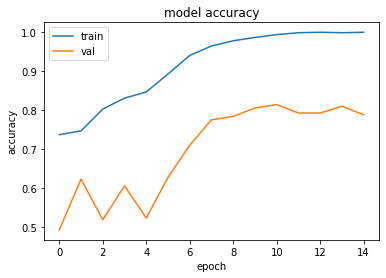

In [28]:
# summarize history for accuracy
plt.plot(csv['accuracy'])
plt.plot(csv['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


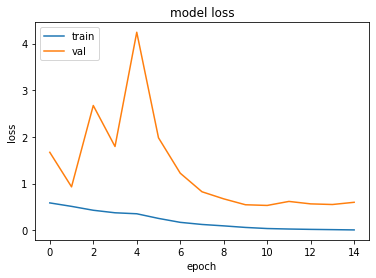

In [29]:
# summarize history for loss
plt.plot(csv['loss'])
plt.plot(csv['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Q: Plotting Predictions
Plot some of model predictions with true labels. Share your insights
### Your Answer:
The model is misclassifying on the basis of contrast and some veins-like branches. Some of the labels look incorrect to the untutored eye as well, where I think the model is picking well.

In [ ]:
model.load_weights(os.path.join(str(data_path), 'Best_Good_Bad_Quality_Image_Weights.hdf5'))

In [ ]:
y_pred=[]
for idx in range(len(X_val)):
    x=cv2.imread(str(image_path)+'/'+X_val[idx])
    x=cv2.resize(x, (224,224))
    op=model.predict(np.expand_dims(img_standardization(x), axis=0),verbose=1)
    y_pred.append(op)
    print (index)

In [59]:
prediction_y=[]

for i in y_pred:
  if i[0][0]>0.5:
    prediction_y.append(0)
  else:
    prediction_y.append(1)

In [60]:
import sklearn.metrics as metrics

print(metrics.classification_report(Y_val, prediction_y))
print(metrics.confusion_matrix(Y_val, prediction_y))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       100
           1       0.79      0.84      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

[[77 23]
 [16 84]]


In [ ]:
for idx, row in enumerate(Y_val):
  if row==prediction_y[idx]:
    plot_image(str(image_path)+'/'+X_val[idx], label=row)

In [ ]:
for idx, row in enumerate(Y_val):
  if row!=prediction_y[idx]:
    plot_image(str(image_path)+'/'+X_val[idx], label=row)

## Q: Improvements
- Is your model making any obvious errors? 
- Compare the results of the CNN model with the simple model you trained earlier. Comment on the outcome of this comparison.

### Your Answer:

1. With the limited understanding of subject matter that I have, I think the model is confused with brightness majorly. Any bright spots on the image, it marks it as a good quality image. Probably misclassified images can oversampled or augmented and the model can be trained. Another way to approach this would be figure out the misclassified samples in the training set and finetune the last few layers of the model on them with a lower learning rate. I also think the labels in the image are a bit subjective and images which are a bit on the bad side have been classified as good.

2. The results in both the models is not much different. Class 0 has 3% less recall in CNN and Class 1 has 6% less recall. Now the thing is statistically these results are not that significant because the simple model had just 60 images in the validation set and here we have more than thrice of them. A model comparison would be ideal on the same evaluation sets.

# Step 3: Multi-level Classification

In this stage, consider building a model to predict the image quality with multiple class labels: good, accept and bad. You are not expected to provide code or achieve perfection! Rather, we would like to at least see in writing what next steps you think are useful and why. Specifically, try to address:
- What methods you would implement from a model and/or data preprocessing standpoint
- What challenges you foresee in implementing your selected model and/or data preprocessing approach
- How you would evaluate a model that predicts these 3-class labels against the previous models?

In [1]:
'''
1. I think if there's a clear definition and labels for what "accept" images are, I'll stick to DenseNet-121 for classification. Else, with some help from medical professionals, one could bucket the current binary classification
model on the basis of thresholds in three different bins. Also, I think using photometric augmentations would help as currently the model is misclassifying images with low brightness

2. Challenges could include interclass misclassification at all the three levels, because when it comes medical images, I think annotating or labeling them involves subjectivity at some point. For example, if the same X-ray is
shown to two radiologists for quality, it is  likely in the extreme case that both have different opinions on the quality. In my experience, this problem is difficult to solve. Since, the model can only be as good as the data. So, I foresee
data annotation and misclassification challenges consequently

3. At an individual class level, I think F-1 score would be a good metric. Another thing would be see the number of cases that are acceptable or good and classified as bad or vica versa. On the other hand,
I think the accept class can be seen combined as a part of the good class in a strategic way (weighted averaging) when comparing against the bad quality images.

'''

'\n1. I think if there\'s a clear definition and labels for what "accept" images are, I\'ll stick to DenseNet-121 for classification. Else, with some help from medical professionals, one could bucket the current binary classification\nmodel on the basis of thresholds in three different bins. Also, I think using photometric augmentations would help as currently the model is misclassifying images with low brightness\n\n2. Challenges could include interclass misclassification at all the three levels, because when it comes medical images, I think annotating or labeling them involves subjectivity at some point. For example, if the same X-ray is\nshown to two radiologists for quality, it is  likely in the extreme case that both have different opinions on the quality. In my experience, this problem is difficult to solve. Since, the model can only be as good as the data. So, I foresee\ndata annotation and misclassification challenges consequently\n\n3. At an individual class level, I think F-1